In [ ]:
!pip install jovian --upgrade --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split

In [ ]:
project_name='pytorch-zero-to-gan-course-project'

Data Prepation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Adjust these paths to match your Google Drive structure
DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks"
TRAIN_DIR = "/content/drive/MyDrive/Colab Notebooks/train"
VAL_DIR = "/content/drive/MyDrive/Colab Notebooks/valid"

# Verify the directories exist
print(f"Train directory exists: {TRAIN_DIR}")
print(f"Validation directory exists: {VAL_DIR}")

# List contents (first 5 items) if directories exist
if os.path.exists(TRAIN_DIR):
    print(f"Contents of train directory: {os.listdir(TRAIN_DIR)[:5]}")
if os.path.exists(VAL_DIR):
    print(f"Contents of validation directory: {os.listdir(VAL_DIR)[:5]}")

Train directory exists: /content/drive/MyDrive/Colab Notebooks/train
Validation directory exists: /content/drive/MyDrive/Colab Notebooks/valid
Contents of train directory: ['AFRICAN CROWNED CRANE', 'ABYSSINIAN GROUND HORNBILL', 'ABBOTTS BOOBY', 'ABBOTTS BABBLER']
Contents of validation directory: ['ABBOTTS BABBLER', 'AFRICAN CROWNED CRANE', 'ABYSSINIAN GROUND HORNBILL', 'ABBOTTS BOOBY']


In [ ]:
transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

train_ds = torchvision.datasets.ImageFolder(root=TRAIN_DIR,
                                           transform=transform_ds)

In [ ]:
num_classes= len(train_ds.classes)
num_classes

4

In [ ]:
val_ds = torchvision.datasets.ImageFolder(root=VAL_DIR,
                                         transform=transform_ds)

In [ ]:
batch_size= 512

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

In [ ]:
def show_images(train_dl):
    for images, labels in train_dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break

Move to GPU

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

Defining Model

In [ ]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch+1, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [ ]:
 class model(ImageClassificationBase):
     def __init__(self, num_classes):
         super().__init__()
         self.network = models.resnet18(pretrained=True)
         number_of_features = self.network.fc.in_features
         self.network.fc = nn.Linear(number_of_features, num_classes)

     def forward(self, xb):
         return self.network(xb)

     def freeze(self):
         for param in self.network.parameters():
             param.requires_grad= False
         for param in self.network.fc.parameters():
             param.requires_grad= True

     def unfreeze(self):
         for param in self.network.parameters():
            param.requires_grad= True

In [ ]:
model = to_device(model(num_classes), device)

Training Phase

In [ ]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0, grad_clip=None,
                 opt_func=torch.optim.Adam):

    torch.cuda.empty_cache()

    history = []
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                                   steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            opt.step()
            opt.zero_grad()

            lrs.append(get_lr(opt))
            sched.step()

        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history


In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.9411828517913818, 'val_acc': 0.20000000298023224}]

Training On Current Dataset

In [ ]:
epochs = 10
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 10e-4
opt_func=torch.optim.Adam

In [ ]:
model.freeze()


In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=weight_decay,
                        grad_clip=grad_clip, opt_func=opt_func)

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [1/10], last_lr: 0.000013, train_loss: 1.7486, val_loss: 1.8184, val_acc: 0.2500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [2/10], last_lr: 0.000067, train_loss: 1.7037, val_loss: 1.7976, val_acc: 0.2500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [3/10], last_lr: 0.000100, train_loss: 1.7219, val_loss: 1.7195, val_acc: 0.2500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [4/10], last_lr: 0.000095, train_loss: 1.6298, val_loss: 1.8246, val_acc: 0.2000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [5/10], last_lr: 0.000081, train_loss: 1.6393, val_loss: 1.6223, val_acc: 0.2000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [6/10], last_lr: 0.000061, train_loss: 1.6582, val_loss: 1.5906, val_acc: 0.2000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [7/10], last_lr: 0.000039, train_loss: 1.5979, val_loss: 1.6907, val_acc: 0.1500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [8/10], last_lr: 0.000019, train_loss: 1.5819, val_loss: 1.6058, val_acc: 0.2000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [9/10], last_lr: 0.000005, train_loss: 1.5636, val_loss: 1.5942, val_acc: 0.2000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [10/10], last_lr: 0.000000, train_loss: 1.5667, val_loss: 1.6240, val_acc: 0.3000


In [ ]:
model.unfreeze()

In [ ]:
epochs = 10
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 10e-4
opt_func = torch.optim.Adam

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                        weight_decay=weight_decay, grad_clip=grad_clip,
                        opt_func=opt_func)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [1/10], last_lr: 0.000013, train_loss: 1.5824, val_loss: 1.4448, val_acc: 0.2500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [2/10], last_lr: 0.000067, train_loss: 1.3459, val_loss: 1.0163, val_acc: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [3/10], last_lr: 0.000100, train_loss: 0.8920, val_loss: 0.5131, val_acc: 0.9500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [4/10], last_lr: 0.000095, train_loss: 0.4730, val_loss: 0.2355, val_acc: 0.9500


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [5/10], last_lr: 0.000081, train_loss: 0.2467, val_loss: 0.0936, val_acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [6/10], last_lr: 0.000061, train_loss: 0.1613, val_loss: 0.0478, val_acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [7/10], last_lr: 0.000039, train_loss: 0.0994, val_loss: 0.0534, val_acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [8/10], last_lr: 0.000019, train_loss: 0.0970, val_loss: 0.0455, val_acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [9/10], last_lr: 0.000005, train_loss: 0.0735, val_loss: 0.0390, val_acc: 1.0000


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: [10/10], last_lr: 0.000000, train_loss: 0.0752, val_loss: 0.0350, val_acc: 1.0000


Test

In [ ]:
TEST_DIR = "/content/drive/MyDrive/Colab Notebooks/test"

Label:  ABBOTTS BABBLER
Prediction:  ABBOTTS BABBLER


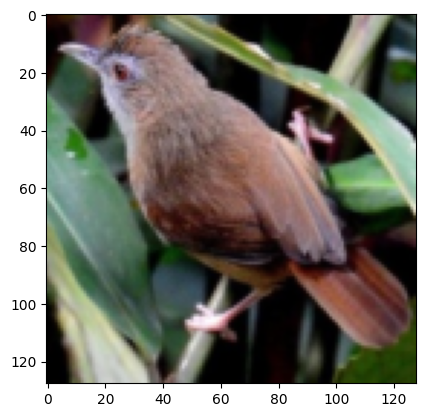

In [ ]:
transform_test = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])
test_ds = torchvision.datasets.ImageFolder(root=TEST_DIR,
                                          transform=transform_test)
def prediction(model, images):
    xb = to_device(images.unsqueeze(0), device)
    out = model(xb)
    _, preds = torch.max(out, dim=1)
    predictions = test_ds.classes[preds[0].item()]
    return predictions
images, labels = test_ds[0]
print("Label: ", test_ds.classes[labels])
print("Prediction: ", prediction(model, images))
plt.imshow(images.permute(1,2,0))

Performance

Text(0, 0.5, 'Accuracy')

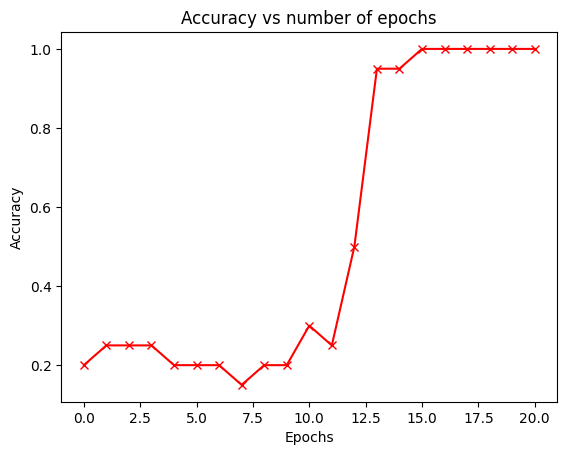

In [ ]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-rx")
plt.title("Accuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0.5, 0, 'Epochs')

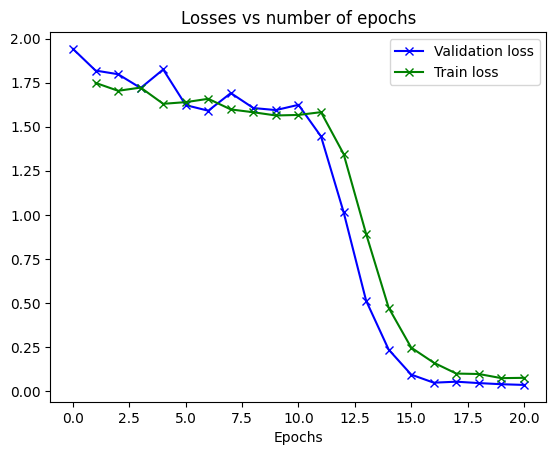

In [ ]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-bx")
plt.plot(train_loss, "-gx")
plt.title("Losses vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")

In [ ]:
torch.save(model.state_dict(), 'BirdsResNet18.pth')

In [ ]:
jovian.commit(project=project_name, output=['BirdsResNet18.pth'])

In [ ]:
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_loss=history[-1]['val_loss'],
                   val_acc=history[-1]['val_acc'])